# Detection Using Selective Search

This notebook contains the steps required for detecting ships in the geo-spatial images using Selective Search. Selective Search works by over-segmenting an image using a superpixel algorithm.

It merges superpixels in a hierarchial fashion based on 5 key points:
1. Color Similarity: Computing  a 25-bin histogram for each channel of an image. Similarity of any 2 regions is measured by the histogram intersection distance.

2. Texture Similarity: For texture, Selective Search extracts the Gaussian derivatives at 8 orientation per channel(3\*8=24). These are used to compute a 10-bin histogram. They are compared using histogram intersection distance.

3. Size Similarity: Smaller regions are grouped earlier. Hierarchial Agglomearative Clustering are prone to clusters reaching a critical mass and then combining every overlapping location.

4. Shape Similarity/compatibility: Two regions are considered compatible if they fir into each other, thereby filling gaps in the regional proposal generation.

5. Meta-similarity measure: Acts a linear combination of color, texture, size and shape similarity.

[Selective Search for Object Recognition](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf)

Installing opencv-contrib as SelectiveSearch Algorithm is still not part of the official package

In [1]:
!pip uninstall -y opencv-python

!pip3 install opencv-contrib-python

Installing *imutils* for non-max suppression libraries

In [2]:
!pip3 install imutils

# Importing the libraries

The libraries required for implementing the *Ship detection* in a geo-spatial image are imported

In [3]:
import numpy as np 
import pandas as pd 
import cv2, os, re
import matplotlib.pyplot as plt
import imutils

from tqdm import tqdm
from imutils.object_detection import non_max_suppression

from tensorflow.keras.models import load_model

# Utitilty Functions

1. find_regions: This method is used for finding Region of Interests(ROI) using the Selective Search Algorithm. There are 2 methods, *fast* and *quality*. The *fast* methods finds the ROI faster but with lesser quality, whie the *quality* finds more ROI at a cost of more time spent

2. load_scenes: Load the geospatial images into a list for object detection.

In [4]:
def find_regions(image, method):
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    
    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    
    rects = ss.process()
    boxes = []
    for (x,y,w,h) in rects:
        
        boxes.append([x,y,w,h])
        pass
    
    return boxes
    pass

In [5]:
scene_path = 'ships-in-satellite-imagery/scenes/scenes'

def load_scenes():
    
    scenes = []
    dirfiles = os.listdir(scene_path)
    dirfiles = sorted(dirfiles)
    for file in dirfiles:
        
        print(os.path.join(scene_path, file))
        scene = cv2.imread(os.path.join(scene_path, file))
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        scenes.append(scene)
        pass
    
    return scenes
    pass

In [6]:
scenes = load_scenes()

ships-in-satellite-imagery/scenes/scenes\lb_1.png
ships-in-satellite-imagery/scenes/scenes\lb_2.png
ships-in-satellite-imagery/scenes/scenes\lb_3.png
ships-in-satellite-imagery/scenes/scenes\lb_4.png
ships-in-satellite-imagery/scenes/scenes\sfbay_1.png
ships-in-satellite-imagery/scenes/scenes\sfbay_2.png
ships-in-satellite-imagery/scenes/scenes\sfbay_3.png
ships-in-satellite-imagery/scenes/scenes\sfbay_4.png


# Finding ROIs

The Region of Interests(ROIs) are found for each loaded scene, depending on the method used, the time taken varies along with the detection. For countering this, it is better to create a feature map of the scene and then finding the ROIs.

1. Fast -> 17min 28s

2. Quality

To change the type of detection, change the *method* variable. Options:
```
fast
quality
```

In [7]:
%%time
method = "quality"

boxes = []

for scene in scenes:
    
    box_in_scene = find_regions(scene, method)
    boxes.append(box_in_scene)
    pass

CPU times: total: 37min 48s
Wall time: 27min 45s


# Loading Saved Model

The model trained in [Ship Detection using Faster R-CNN: Part 1](https://www.kaggle.com/apollo2506/ship-detection-using-faster-r-cnn) on the dataset is loaded along with the weights obtained from the model. The current model is based upon the class weights. For the model based upon augmentation, Part 1 will have to be run with **AUGMENTATION** set to *True*.

In [8]:
model = load_model('ship-detection-using-faster-r-cnn/ship-model.h5')

model.summary()

Model: "Feature_Extraction_and_FC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 58, 58, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 29, 29, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_conv1 (BatchNormalization)   │ (None, 29, 29, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2A_branch2a (Conv2D)       │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2A_branch2a                  │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3A_branch2a (Conv2D)       │ (None, 7, 7, 32)       │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3A_branch2a                  │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4A_branch2a (Conv2D)       │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4A_branch2a                  │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 62,532 (244.27 KB)

 Trainable params: 62,242 (243.13 KB)

 Non-trainable params: 288 (1.12 KB)

 Optimizer params: 2 (12.00 B)

# Predicting the ROIs

The ROIs for each scene are taken and run through the model. ROIs with scaling factor greater than 0.10 are ignored as they are to be big for the and lead to uncessary ROIs being predicted. The scaling factor in an ideal situation should vary between 0.10 and 0.15, as they are the sweet spots, where a ship inside a ROI but not an entire city block.

Bounding boxes are drawn around each detected object if it is classified as a ship, otherwise not. The resulting images are stored in the *images* list for displaying.

In [11]:
%%time

rois, locs = [], []
images = []
for i,scene in tqdm(enumerate(scenes)):
    
    (H, W) = scene.shape[:2]
    region, loc = [],[]
    for (x,y,w,h) in boxes[i]:

        if w/float(W) < 0.01 and h/float(H) < 0.01:
            continue

        roi = scene[y:y+h,x:x+w]
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (48,48))

        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        pass
    
    preds = model.predict(np.array(rois,dtype=np.float32))
    preds = np.argmax(preds, axis=1)
    
    img = scene.copy()
    for (i,label) in enumerate(preds):

        if label == 1:
            (startX,startY,endX,endY) = locs[i]
            cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
        pass
    
    images.append(img)
    del rois[:]
    del locs[:]
    pass

0it [00:00, ?it/s]

866/866 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


1it [00:06,  6.59s/it]

420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


2it [00:09,  4.60s/it]

1391/1391 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step


3it [00:27, 10.73s/it]

1037/1037 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step


4it [00:43, 12.78s/it]

1713/1713 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step


5it [01:11, 18.17s/it]

1284/1284 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step


6it [01:30, 18.58s/it]

861/861 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step


7it [01:43, 16.66s/it]

543/543 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


8it [01:51, 13.91s/it]

CPU times: total: 6min 17s
Wall time: 1min 51s


# Displaying final Images

The final images containing the predicted bounding boxes are displayed in the next code block.

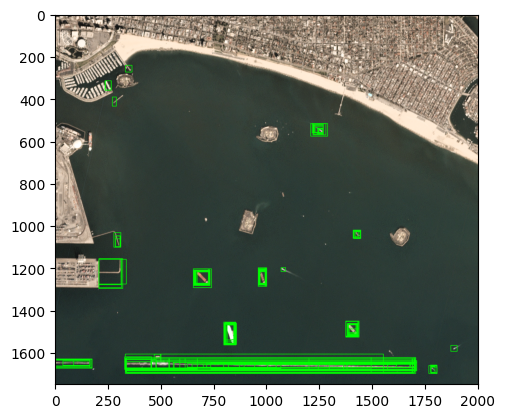

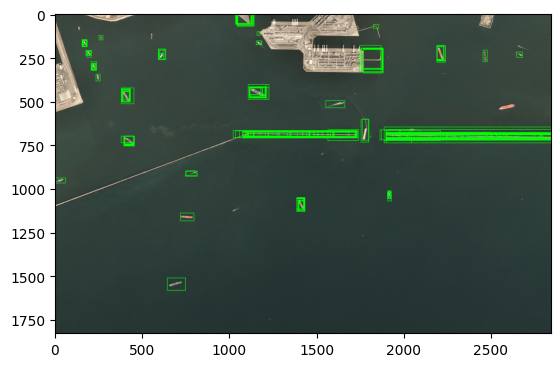

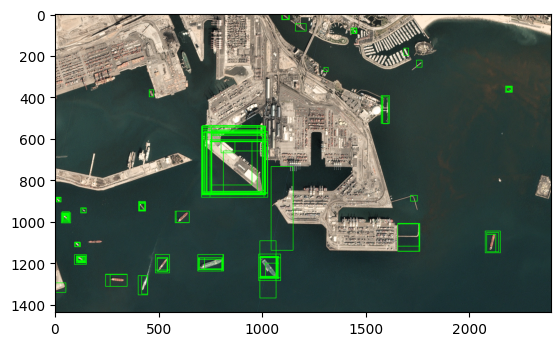

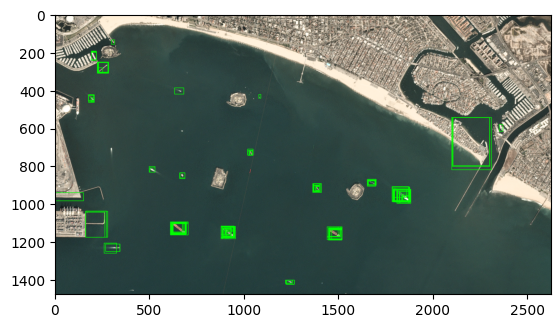

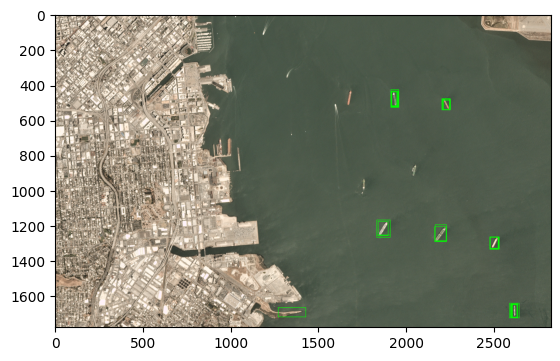

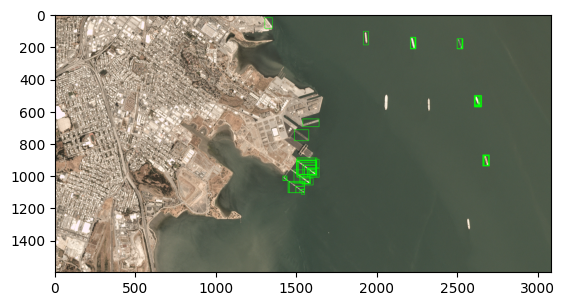

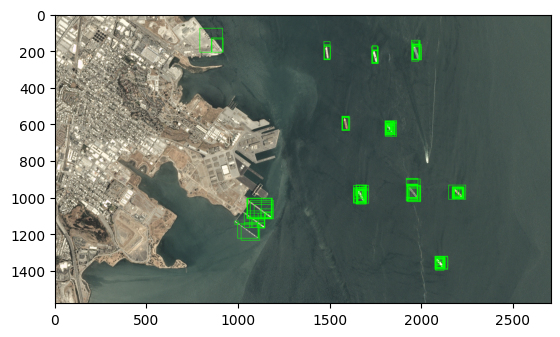

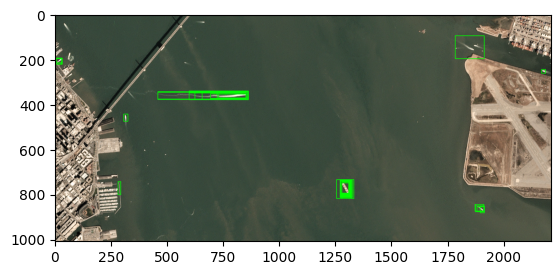

In [12]:
for image in images:
    
    plt.imshow(image)
    plt.show()